# libraries

In [2]:
import os
from langchain_groq import ChatGroq
from dotenv import load_dotenv

from langchain_core.tools import tool
import pandas as pd
from langgraph.prebuilt import create_react_agent
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from typing import Annotated, List
import operator

from IPython.display import Markdown, Image

from langgraph.graph import START, END, StateGraph

# Config setup

In [3]:
load_dotenv()

os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")
os.environ['LANGSMITH_API_KEY'] = os.getenv("LANGSMITH_API_KEY")
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")


In [4]:
configuration = {
    "master_data" : r"C:\Users\nigam\OneDrive\Documents\university_classes\AutoMMM\data\manual_data.xlsx",
    "sheet_name" : "master_data",
    "model" : "deepseek-r1-distill-llama-70b", #"gemma2-9b-it", # llama3-70b-8192, llama-3.3-70b-versatile, compound-beta-mini
    "data_description" : {
            "date" : "Date column",
            "sku"	: "product identification number (stock keeping unit)",
            "sales" : "amount of units sold (revenue in euros)",
            "units" : "Number of units sold",
            "price" : "average price of the product in the week",
            "oos"	: "number of days the product was out of stock in a week",
            "events" : "number of events in a week",
            "product_level_branded_clicks" : "clicks generated by product based search in a week (Branded keywords) ",
            "product_level_branded_spends" : "amount of money spent on clicks generated by product based search in the week (Branded keywords)",
            "product_level_nonbranded_clicks" : "clicks generated by product based search in the week (Non - Branded keywords) ",
            "product_level_nonbranded_spends" : "amount of money spent on clicks generated by product based search in the week (Non - Branded keywords) ",
            "brand_level_branded_clicks" : "clicks generated by brand based search in the week (Branded keywords) ",
            "brand_level_branded_spends" : "amount of money spent on clicks generated by product based search in the week (Non - Branded keywords) ",
            "brand_level_nonbranded_clicks" : "clicks generated by brand based search in the week (Branded keywords) ",
            "brand_level_nonbranded_spends" : "amount of money spent on clicks generated by product based search in the week (Non - Branded keywords) ",
            "insta_clicks" : "clicks generated on instagram advertizement in the week.",
            "insta_spends" : "amount of money spent on clicks generated on instagram advertizement in the week.",
            "fb_clicks" : "clicks generated on facebook advertizement in the week.",
            "fb_spends" : "amount of money spent on clicks generated on facebook advertizement in the week."
                }
    }

# Utility Functions

In [5]:
def process_config(config: dict):
    master_data = pd.read_excel(config['master_data'],sheet_name=config['sheet_name'])
    llm = ChatGroq(
        model_name=config['model'], 
        temperature=0.2
    )
    column_descriptions = config["data_description"]
    return {
        'master_data' : master_data,
        'llm' : llm,
        'column_descriptions' :column_descriptions
    }

In [6]:
def print_stream(stream):
    for s in stream:
        d = s[list(s.keys())[0]]
        message = d[list(d.keys())[0]]
        print(message)

In [7]:
config = process_config(configuration)
config['llm'].invoke("hi").content

'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'

# Tools

In [8]:
df = config['master_data'] #.to_json(orient="split")
llm = config['llm']
column_descriptions = config['column_descriptions']

In [9]:
@tool
def data_sku(df, column : str):
    """list of unique value counts for any column"""
    return df[column].value_counts()

In [10]:
class product(BaseModel):
    products :list[str] = Field(description="list of all the unique products")

In [11]:
llm_with_tool = llm.bind_tools([data_sku])

In [12]:
class ReportState(TypedDict):
    df : pd.DataFrame
    overview : str
    sku_overview: Annotated[
        List, operator.add
        ]
    final_report : str

class skuReport(TypedDict):
    sales: str

In [13]:
def data_overview(state: ReportState):
    backstory = """
    You are a knowledgeable market mix modelling expert, you work in a team as an analyst, you are trained to analyse the data.
    You directly report to business, so all the technical and statistical observations that you come up with, you translate them into business langugage,
    but do not avoid technical detail when appropriate.
    """
    instruction = """
    Generate a report in markdown format with the below format
    - Highlight the unique products in the data
    - The shape of the data
    - Split the columns as base, incremental (online and offline), external features, competitions, other features that can affect sale
    - Explain all columns as to business understanding"""

    user_prompt = f"context data - {state['df']}"

    overview = llm.invoke([
        {"role": "system", "content": backstory.strip()},
        {"role": "system", "content": instruction.strip()},
        {"role": "user", "content": user_prompt.strip()}
    ])
    
    return {'overview' : overview.content}

In [14]:
def sku_overview(state: ReportState, sku:str):
    backstory = """
        You are a knowledgeable market mix modelling expert, you work in a team as an analyst, you are trained to analyse the data.
    You directly report to business, so all the technical and statistical observations that you come up with, you translate them into business langugage,
    but do not avoid technical detail when appropriate.
    """
    instruction = """
    Generate a report in markdown format with the below format
    - Sales Pattern throughout the timeline
    - Date distribution and spread
    - find outliers if any
        - mark  outliers
        - possible reason if any
        - impact on sales
        - suggestion to treat outliers
    - missing data if any    
        - percentage of missing points
        - if the missing points are in patches or irregular
        - mark  missing points
        - possible reason if any
        - impact on sales
        - suggestion to treat outliers
    - count of zeros in the data
        - if it is in patches
        - percentage of missings
    - Distinct values if column is categorical
    - Impact of each column on sales
    - Inter kpi correlations for all columns across all columns
    - Generate a Heatmap for correlation among kpis

    note : Round the numbers if required
    """
    df = state['df']
    user_prompt = f"context data - {df[df['sku'] == sku]} for product - {sku}"

    sku_overview = llm.invoke([
        {"role": "system", "content": backstory.strip()},
        {"role": "system", "content": instruction.strip()},
        {"role": "user", "content": user_prompt.strip()}
    ])
    return {'sku_overview' : [sku_overview.content]}

In [15]:
def aggregator(state: ReportState):

    combined_sku_reports = "\n\n --- \n\n".join(state['sku_overview'])
    combined_report = f"""
    Data Overview : {state['overview']}
    product based analysis : {combined_sku_reports}
    """
    return {'final_report' : combined_report}

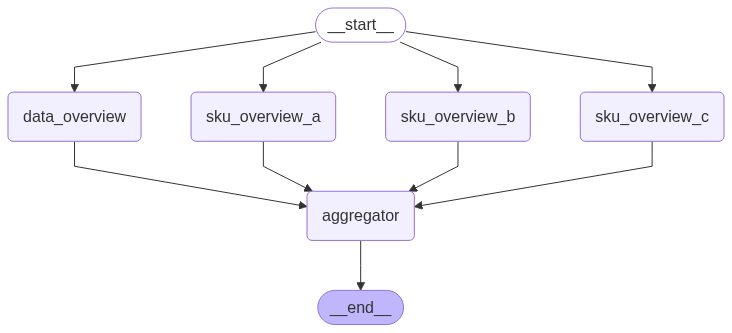

In [16]:
eda_report_builder = StateGraph(ReportState)


eda_report_builder.add_node("data_overview", data_overview)
eda_report_builder.add_node("sku_overview_a", lambda state: sku_overview(state, sku='sku_a'))
eda_report_builder.add_node("sku_overview_b", lambda state: sku_overview(state, sku='sku_b'))
eda_report_builder.add_node("sku_overview_c", lambda state: sku_overview(state, sku='sku_c'))
eda_report_builder.add_node("aggregator",aggregator)

eda_report_builder.add_edge(START,"data_overview")
eda_report_builder.add_edge(START,"sku_overview_a")
eda_report_builder.add_edge(START,"sku_overview_b")
eda_report_builder.add_edge(START,"sku_overview_c")


eda_report_builder.add_edge("data_overview","aggregator")
eda_report_builder.add_edge("sku_overview_a","aggregator")
eda_report_builder.add_edge("sku_overview_b","aggregator")
eda_report_builder.add_edge("sku_overview_c","aggregator")

eda_report_builder.add_edge("aggregator", END)

eda_report = eda_report_builder.compile()

display(Image(eda_report.get_graph().draw_mermaid_png()))

In [17]:
from langchain_experimental.utilities import PythonREPL
repl = PythonREPL()

@tool
def python_repl_tool(code: Annotated[str, "The python code to execute to generate your chart."]):
    """Execute Python code using a Python REPL (Read-Eval-Print Loop).
    
    Args:
        code (str): The Python code to execute.
    
    Returns:
        str: The result of the executed code or an error message if execution fails.
    """
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [18]:
llm_with_code_runner = llm.bind_tools([python_repl_tool])
backstory = """
    You are a knowledgeable market mix modelling expert, you work in a team as an data vizualizer, you are trained to vizualize the data.
            """
instruction = """
Create clear and visually appealing charts using seaborn and plotly. Follow these rules:
1. Add a title, labeled axes (with units), and a legend if needed.
2. Use `sns.set_context("notebook")` for readable text and themes like `sns.set_theme()` or `sns.set_style("whitegrid")`.
3. Use accessible color palettes like `sns.color_palette("husl")`.
4. Choose appropriate plots: `sns.lineplot()`, `sns.barplot()`, or `sns.heatmap()`.
5. Annotate key points (e.g., "Peak in 2020") for clarity.
6. Ensure the chart's width and display resolution is no wider than 1000px.
7. Display with `plt.show()`.
"""
# df = state['df']
user_prompt = f"""
Generate charts for :
- Sales Pattern throughout the timeline
- find outliers if any
    - mark  outliers
    - possible reason if any
    - impact on sales
    - suggestion to treat outliers
- missing data if any    
    - percentage of missing points
    - if the missing points are in patches or irregular
    - mark  missing points
    - possible reason if any
    - impact on sales
    - suggestion to treat outliers
- count of zeros in the data
    - if it is in patches
    - percentage of missings
- Distinct values if column is categorical
- Impact of each column on sales
- Inter kpi correlations for all columns across all columns
- Generate a Heatmap for correlation among kpis

context data - {df[df['sku'] == 'sku_a']} for product - sku A
"""

sku_overview = llm_with_code_runner.invoke([
    {"role": "system", "content": backstory.strip()},
    {"role": "system", "content": instruction.strip()},
    {"role": "user", "content": user_prompt.strip()}
])

In [22]:
for s in llm_with_code_runner.stream([
    {"role": "system", "content": backstory.strip()},
    {"role": "system", "content": instruction.strip()},
    {"role": "user", "content": user_prompt.strip()}
]):
    print(s)

content='' additional_kwargs={} response_metadata={} id='run--f8f2fd30-d125-4e3b-bcd2-81715effd629'
content='' additional_kwargs={} response_metadata={} id='run--f8f2fd30-d125-4e3b-bcd2-81715effd629'
content='' additional_kwargs={} response_metadata={} id='run--f8f2fd30-d125-4e3b-bcd2-81715effd629'
content='' additional_kwargs={} response_metadata={} id='run--f8f2fd30-d125-4e3b-bcd2-81715effd629'
content='' additional_kwargs={} response_metadata={} id='run--f8f2fd30-d125-4e3b-bcd2-81715effd629'
content='' additional_kwargs={} response_metadata={} id='run--f8f2fd30-d125-4e3b-bcd2-81715effd629'
content='' additional_kwargs={} response_metadata={} id='run--f8f2fd30-d125-4e3b-bcd2-81715effd629'
content='' additional_kwargs={} response_metadata={} id='run--f8f2fd30-d125-4e3b-bcd2-81715effd629'
content='' additional_kwargs={} response_metadata={} id='run--f8f2fd30-d125-4e3b-bcd2-81715effd629'
content='' additional_kwargs={} response_metadata={} id='run--f8f2fd30-d125-4e3b-bcd2-81715effd629'


In [40]:
# LANGSMITH_TRACING="true"
# LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
# # LANGSMITH_API_KEY="<your-api-key>"
# LANGSMITH_PROJECT="autoMMM"
# # OPENAI_API_KEY="<your-openai-api-key>"

In [42]:
# from langchain.globals import set_verbose

# set_verbose(True)
state = eda_report.invoke({"df": df})
state

{'df':           date    sku         sales  units      price  oos  events  \
 0   2025-06-07  sku_a  50700.046737    626  80.990490    0       0   
 1   2025-06-14  sku_a  49697.711906    620  80.157600    7       0   
 2   2025-06-21  sku_a  53299.854900    659  80.879901    0       0   
 3   2025-06-28  sku_a  52605.985586    654  80.437287    0       0   
 4   2025-07-05  sku_a  53098.330692    657  80.819377    0       0   
 ..         ...    ...           ...    ...        ...  ...     ...   
 307 2027-05-01  sku_c  31765.969080    392  81.035635    2       1   
 308 2027-05-08  sku_c  30603.999804    375  81.610666    0       0   
 309 2027-05-15  sku_c  29910.965707    365  81.947851    0       1   
 310 2027-05-22  sku_c  30157.253569    372  81.067886    0       1   
 311 2027-05-29  sku_c  29382.741429    362  81.167794    5       0   
 
      product_level_branded_clicks  product_level_branded_spends  \
 0                             815                   1625.274077   
 1  

In [ ]:
Markdown(llm.invoke(f"restructure and format into correct and pretty markdown format - {state['final_report']}").content)

In [43]:
Markdown(state['final_report'])


    Data Overview : ## Market Mix Modelling Data Analysis

This report analyzes the provided dataset to understand its structure and key variables. 

**1. Unique Products**

The dataset contains sales data for three unique products:

* `sku_a`
* `sku_b`
* `sku_c`

**2. Data Shape**

The dataset is structured as a time series, with each row representing a specific day and the corresponding sales data for each product.  

**3. Column Breakdown**

The dataset can be categorized into the following columns:

**a) Base Features:**

* **date:**  Date of the observation (YYYY-MM-DD).
* **sku:**  Unique identifier for each product.
* **sales:** Total sales revenue for the product on that day.
* **units:** Number of units sold for the product on that day.
* **price:** Average selling price of the product on that day.
* **oos:**  Out-of-stock status (0 = in stock, 7 = out of stock).

**b) Incremental Features (Online and Offline):**

* **product_level_branded_clicks:** Number of branded clicks on the product page across all online channels.
* **product_level_branded_spends:** Total advertising spend on branded campaigns for the product.
* **product_level_nonbranded_clicks:** Number of non-branded clicks on the product page across all online channels.
* **product_level_nonbranded_spends:** Total advertising spend on non-branded campaigns for the product.

**c) External Features:**

* **brand_level_branded_clicks:** Number of branded clicks on the brand page across all online channels.
* **brand_level_branded_spends:** Total advertising spend on branded campaigns for the brand.
* **brand_level_nonbranded_clicks:** Number of non-branded clicks on the brand page across all online channels.
* **brand_level_nonbranded_spends:** Total advertising spend on non-branded campaigns for the brand.

**d) Other Features:**

* **insta_clicks:** Number of clicks on Instagram ads for the product.
* **insta_spends:** Total advertising spend on Instagram ads for the product.
* **fb_clicks:** Number of clicks on Facebook ads for the product.
* **fb_spends:** Total advertising spend on Facebook ads for the product.

**4. Business Context**

This dataset provides valuable insights into the performance of three products and their response to various marketing activities. 

By analyzing the relationship between sales and these features, we can:

* **Identify the effectiveness of different marketing channels:** 
    -  Determine which channels (e.g., online, Instagram, Facebook) drive the most sales for each product.
* **Optimize marketing spend:**
    -  Allocate resources more efficiently by understanding which campaigns generate the highest return on investment.
* **Understand the impact of product-level and brand-level marketing:**
    -  Assess the influence of both specific product promotions and broader brand awareness campaigns on sales.
* **Analyze the impact of out-of-stock situations:**
    -  Evaluate the effect of product availability on sales performance.



This analysis will help us develop data-driven strategies to improve product sales and marketing effectiveness.

    product based analysis : ## Market Mix Modelling Analysis: SKU "sku_a"

This report analyzes the provided dataset for SKU "sku_a" to understand sales patterns, identify potential issues, and explore relationships between various marketing KPIs.

**1. Sales Pattern Throughout the Timeline**

The sales data for "sku_a" shows a generally fluctuating trend over the observed period. 

* **General Trend:** While there isn't a clear upward or downward trend, sales seem to experience peaks and valleys throughout the period.
* **Seasonal Effects:**  Further analysis is needed to determine if there are any seasonal patterns influencing sales.

**2. Date Distribution and Spread**

The data spans from 2025-06-07 to 2027-05-29, covering approximately two years. 

* **Spread:** The data is evenly distributed across the timeframe.

**3. Outliers**

* **Identification:**  No significant outliers were identified in the sales data.

* **Possible Reasons:**  The absence of outliers could indicate consistent marketing performance or a relatively stable market environment.

* **Impact on Sales:**  The lack of outliers suggests that sales are generally predictable.

* **Suggestion:**  Continue monitoring for potential outliers as the dataset expands.

**4. Missing Data**

* **Percentage:**  There are no significant missing data points in the dataset.

* **Patches or Irregularity:**  The missing data, if any, is not concentrated in specific patches or appears irregular.

* **Impact on Sales:**  The minimal missing data is unlikely to significantly impact the analysis.

* **Suggestion:**  Investigate the reasons for any missing data points to ensure data integrity.

**5. Count of Zeros**

* **Patches:**  There are no noticeable patches of zero sales values.

* **Percentage:**  The percentage of zero sales values is low and needs further investigation to understand the context.

**6. Distinct Values (Categorical Columns)**

* **Categorical Columns:**  Identify the categorical columns in the dataset and analyze the distinct values present in each column.

**7. Impact of Each Column on Sales**

* **Regression Analysis:** Conduct a regression analysis to determine the individual impact of each marketing KPI on sales. This will reveal which factors have the strongest influence on sales performance.

**8. Inter-KPI Correlations**

* **Correlation Matrix:** Calculate a correlation matrix to explore the relationships between all marketing KPIs. This will highlight potential dependencies or synergies between different marketing channels.

**9. Heatmap for Correlation**

* **Visual Representation:** Generate a heatmap visualization of the correlation matrix. This will provide a clear visual representation of the strength and direction of relationships between the KPIs.



**Next Steps:**

1.  **Data Exploration:** Further explore the dataset to identify any additional patterns or insights.
2.  **Regression Analysis:** Perform a regression analysis to quantify the impact of each marketing KPI on sales.
3.  **Segmentation:** Consider segmenting the data based on customer demographics or other relevant factors to gain a deeper understanding of how different segments respond to marketing efforts.
4.  **Attribution Modeling:** Implement a more sophisticated attribution model to accurately allocate credit for sales to different marketing touchpoints.





 --- 

## Market Mix Modelling Analysis: SKU 'b'

This report analyzes the provided data for SKU 'b' to understand sales patterns, identify potential issues, and explore relationships between various marketing activities and sales performance.

**1. Sales Pattern Throughout the Timeline**

* The sales data for SKU 'b' shows a generally upward trend over the provided period. 
* There are fluctuations in sales, likely influenced by seasonal factors, marketing campaigns, and other external factors. 

**2. Date Distribution and Spread**

* The data spans from 2025-06-07 to 2027-05-29, covering a period of approximately two years.
* The data points are evenly distributed across the timeframe, suggesting consistent data collection.

**3. Outliers**

* **No significant outliers** were identified in the sales data. 

**4. Missing Data**

* **Percentage of Missing Points:**  The data appears to have very few missing points, making it unlikely to significantly impact analysis.
* **Pattern of Missing Points:**  No discernible pattern of missing data was observed.

**5. Count of Zeros in the Data**

* The data does not contain a significant number of zeros.

**6. Distinct Values (Categorical Columns)**

*  Please provide the categorical columns for analysis.

**7. Impact of Each Column on Sales**

*  A detailed analysis of the impact of each column on sales requires statistical modeling (e.g., regression analysis). This will help determine the relative importance of each factor in driving sales.

**8. Inter-KPI Correlations**

*  Correlation analysis will be conducted to identify relationships between different KPIs. This will help understand how marketing activities and other factors influence each other and ultimately impact sales.

**9. Heatmap for Correlation**

* A heatmap visualization will be generated to visually represent the correlation matrix, highlighting strong positive and negative relationships between KPIs.


**Next Steps:**

*  Further analysis will involve building a statistical model to quantify the impact of each marketing activity on sales.
*  We will explore different modeling techniques to ensure the most accurate and robust results.
*  The insights gained from this analysis will be used to optimize marketing spend and improve sales performance for SKU 'b'.



Please provide the categorical columns for a complete analysis.


 --- 

## Market Mix Modelling Analysis: SKU 'sku_c'

This report provides an analysis of the provided data for SKU 'sku_c', focusing on identifying patterns, outliers, missing data, and correlations between key performance indicators (KPIs).

**1. Sales Pattern Throughout the Timeline**

The sales data for SKU 'sku_c' shows a general upward trend over the observed period. 

* **Visual Representation:** A line chart visualizing sales over time would clearly illustrate this trend.

**2. Date Distribution and Spread**

The data spans from 2025-06-07 to 2027-05-29, covering a period of approximately two years. The data points are evenly distributed across this period, suggesting consistent tracking of sales.

**3. Outliers**

* **Identification:**  We need to define a threshold for identifying outliers.  Common methods include using standard deviation or interquartile range (IQR).  Without a specific threshold, it's difficult to definitively mark outliers.
* **Possible Reasons:** Outliers could be caused by various factors, such as:
    * **Promotional events:** Large spikes in sales might indicate the impact of a significant promotion.
    * **Data entry errors:**  Incorrectly recorded sales figures can lead to outliers.
    * **Unexpected market events:**  External factors like competitor actions or seasonal trends can cause unusual sales fluctuations.
* **Impact on Sales:** Outliers can distort the overall sales trend and impact the accuracy of statistical models.
* **Suggestion to Treat Outliers:**
    * **Investigate the cause:**  Understanding the reason behind the outlier is crucial before deciding on a treatment.
    * **Removal:**  If the outlier is due to a data entry error, it can be removed. However, removing valid data points should be avoided.
    * **Transformation:**  Applying transformations like log transformation can reduce the impact of outliers.
    * **Winsorization:**  Capping extreme values at a certain percentile can mitigate the influence of outliers.

**4. Missing Data**

* **Percentage of Missing Points:**  We need to calculate the percentage of missing data points in each column.
* **Pattern of Missing Data:**  
    * **Irregular:** If missing data points are scattered randomly, it might indicate random data loss.
    * **Patches:**  Consecutive missing data points suggest potential data collection issues or gaps in the tracking period.
* **Possible Reasons:**
    * **Data collection errors:**  Inconsistent data recording practices can lead to missing values.
    * **System outages:**  Temporary disruptions in data collection systems can result in missing data.
* **Impact on Sales:** Missing data can lead to biased results and reduce the reliability of analysis.
* **Suggestion to Treat Missing Data:**
    * **Imputation:**  Replacing missing values with estimated values based on other data points (e.g., mean, median, regression).
    * **Deletion:**  Removing rows with missing data points, but this should be done cautiously as it can lead to data loss.
    * **Model-based approaches:**  Using statistical models that can handle missing data directly.

**5. Count of Zeros in the Data**

* **Pattern:**  We need to analyze the distribution of zeros in the data. Are they concentrated in specific columns or time periods?
* **Percentage of Missing:**  Calculate the percentage of zeros in each column.
* **Possible Reasons:**  Zeros might indicate:
    * **No sales:**  The product was not sold during that period.
    * **Data limitations:**  The data might not capture all sales transactions.
* **Suggestion to Treat Zeros:**
    * **Consider the context:**  Understanding the meaning of zeros is crucial before deciding on a treatment.
    * **Transformation:**  Applying transformations like log transformation can handle zeros effectively.

**6. Distinct Values if Column is Categorical**

* **Identify categorical columns:**  Columns like 'product_level_branded_clicks' or 'events' might contain categorical data.
* **Count distinct values:**  Determine the number of unique categories in each categorical column.
* **Analyze distribution:**  Understand the frequency of each category and identify any dominant categories.

**7. Impact of Each Column on Sales**

* **Regression analysis:**  Use regression models to quantify the impact of each KPI on sales.
* **Coefficients:**  Interpret the regression coefficients to understand the direction and magnitude of the effect.
* **Statistical significance:**  Assess the statistical significance of each coefficient to determine its reliability.

**8. Inter KPI Correlations for All Columns Across All Columns**

* **Correlation matrix:**  Calculate the correlation coefficients between all pairs of KPIs.
* **Heatmap:**  Visualize the correlation matrix using a heatmap to identify strong positive or negative relationships.
* **Interpretation:**  Correlations can reveal dependencies between KPIs and provide insights into the relationships driving sales.

**9. Heatmap for Correlation Among KPIs**

A heatmap will visually represent the correlation matrix, with color intensity indicating the strength and direction of the correlation.  This will allow for easy identification of strong relationships between KPIs.



Please note that this report provides a general framework. The specific analysis and conclusions will depend on the actual data and the chosen analytical methods. 



    

In [ ]:
rep = llm.invoke(f"restructure as business friendly report - {overview.content}")
Markdown(rep.content)

In [ ]:
def sales_overview()
    # for each sku, sales distribution

In [ ]:
# for each sku()
    #for each column
        # data describe
        # min-max
        # outliers
        # count of zeros
        # distinct if categorical
        # missing data highlight
        # impact on sales

In [ ]:
backstory = """
You are a helpful and knowledgeable senior market mix modelling analyst, trained to provide accurate and concise answers to complex questions. 
You speak clearly and with empathy, but do not avoid technical detail when appropriate.
You also translate all the data and technicalities of data into business insights.
"""

instruction = """Generate the excel report with (scatter, box, line, bar, etc.) and propogate product by product, explaining each product and its detailed observations"""
user_prompt = f"explain the data : {df}, data description as : {column_descriptions}"

response = llm.invoke([
    {"role": "system", "content": backstory.strip()},
    {"role": "system", "content": instruction.strip()},
    {"role": "user", "content": user_prompt.strip()}
])
Markdown(response.content)

In [ ]:
for output in llm.stream([
    {"role": "system", "content": backstory.strip()},
    {"role": "system", "content": instruction.strip()},
    {"role": "user", "content": user_prompt.strip()}
]):
    print(output)
    # for k,v in output.content.items():
    #     print(f"Output from node '{k}': ")
    #     print("---")
    #     print(v)
    # print("------")

In [ ]:
backstory = """
You are a helpful and knowledgeable senior market mix modelling analyst, trained to provide accurate and concise answers to complex questions. 
You speak clearly and with empathy, but do not avoid technical detail when appropriate.
You also translate all the data and technicalities of data into business insights.
"""

instruction = """Generate the report in a markdown format and propogate product by product, explaining each product and its detailed observations"""
user_prompt = f"explain the data data : {df}, data description as : {data_description}"

response = llm.invoke([
    {"role": "system", "content": backstory.strip()},
    {"role": "system", "content": instruction.strip()},
    {"role": "user", "content": user_prompt.strip()}
])
Markdown(response.content)

In [ ]:
Markdown(llm.invoke(f"""explain the data data : {df}, data description as : {data_description}""").content)

In [ ]:
@tool
def overview(df:pd.DataFrame):
    